## Wprowadzenie
Skrypt pokazuje jak użyć pakietu SciKit do grupowania danych. Rozważane są dwa przykłady: dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich oraz dane IRIS.

In [5]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN

In [34]:
import matplotlib.colors as colors
from itertools import cycle
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
import scipy.spatial.distance as dist


def dunnIndex(data, labels, classes):
    
    distM = dist.cdist(data, data)
    
    minOut = np.inf
    maxIn = -np.inf
    
    for cl in classes:
        if(not (labels==cl).any()):
            continue
        thisClassM = distM[labels == cl, :]
        otherClassM = thisClassM[:, np.logical_not(labels == cl)]
        thisClassM = thisClassM[:, labels == cl]
        mask = np.ones(thisClassM.shape, dtype=bool)
        np.fill_diagonal(mask, 0)
        if(thisClassM.shape[0]>1):
            currMax = np.max(thisClassM[mask])
            if(currMax>maxIn):
                maxIn = currMax
        
        currMin = np.min(otherClassM)
        if(currMin<minOut):
            minOut = currMin
        
    return minOut/maxIn

def DBindex(data, centers, labels, classes):
    
    distDataCenters = np.zeros(len(classes))
    distM = dist.cdist(data, data)
    for cl in classes:
        distDataCenters[cl] = (np.linalg.norm(data[labels==cl] - centers[cl, :]))/np.sqrt(np.array([labels==cl]).sum())
    
    distDataCenters=np.array(distDataCenters)
    centersDist = dist.cdist(centers, centers)
    
    R=np.zeros((len(centers), len(centers)))
    mask = np.ones(R.shape, dtype=bool)
    np.fill_diagonal(mask, 0)
    
    R+=distDataCenters
    R+=distDataCenters.reshape(-1, 1)
    R[mask] = R[mask]/centersDist[mask]
    
    
    D = np.max(R[mask], axis=0)
    T=len(classes)
    return np.sum(D)/T


def countCoeffs(data, labels, centers):
    SH = metrics.silhouette_score(X, labels, metric='euclidean')
    print "silhouette score: ", SH
    print "dunn index: ", dunnIndex(data, labels, set(list(labels)))
    if(not centers is None):
        print "DB index: ", DBindex(data, centers, labels, set(list(labels)))

def plot_data(data, dims, groups, centers):
    d = len(dims)
    plt.figure(figsize=(15, 15))
    for i in range(d):
        for j in range(d):
            plt.subplot(d, d, i*d+j+1)
            plt.scatter(data[:, dims[i]], data[:, dims[j]], c=groups, marker='o', lw = 0)
            if(not centers is None):
                plt.scatter(centers[:, dims[i]], centers[:, dims[j]], c="Black", marker='o')
            plt.xticks([]) 
            plt.yticks([])
    plt.show()

def plotClustering(X, plt_labels):
    plt_colors = cycle(colors.cnames.keys())

    plt_K = np.unique(plt_labels).size

    for k in xrange(plt_K):
        color = plt_colors.next()
        mask = (plt_labels == k)
        plt.plot(X[mask, 0], X[mask, 1], 'w', markerfacecolor=color, marker='o')

    plt.show()

## 1. Pierwszy zestaw danych
Dwuwymiarowe dane wygenerowane losowo z mieszaniny rozkładów gaussowskich

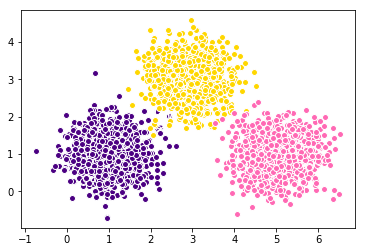

silhouette score:  0.67762573338
dunn index:  0.0171434637994


In [8]:
from sklearn import datasets

centers_ = [[1, 1], [3, 3], [5, 1]]
X, labels = datasets.make_blobs(n_samples=3000, n_features=2, centers=centers_, cluster_std=0.5)

plotClustering(X, labels)
countCoeffs(X, labels, None)

### Grupowanie za pomocą KMeans

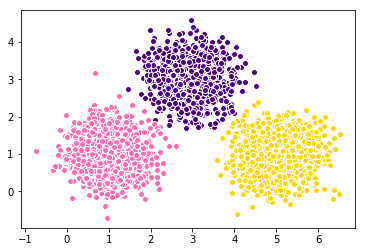

silhouette score:  0.679752286561
dunn index:  0.0298570201569
DB index:  0.164826610468


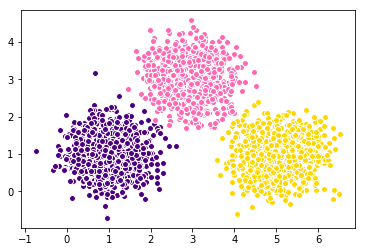

silhouette score:  0.679752286561
dunn index:  0.0298570201569
DB index:  0.164826610468


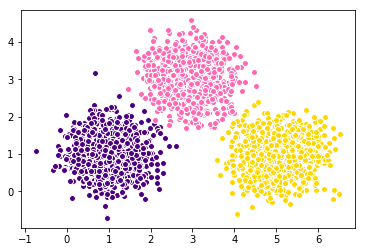

silhouette score:  0.679752286561
dunn index:  0.0298570201569
DB index:  0.164826610468


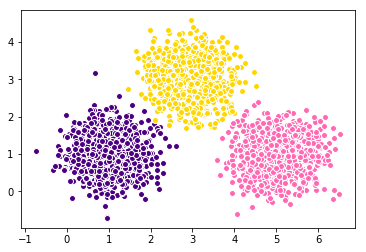

silhouette score:  0.679752286561
dunn index:  0.0298570201569
DB index:  0.164826610468


In [35]:
#n_init - algorytm wykonuje się tyle razy, a potem wybierany jest najlepszy wynik
for i in [1, 5, 10, 100]:
    plt.figure(i)
    k_means = KMeans(init='k-means++', n_clusters=3, n_init=i)
    k_means.fit(X)

    plotClustering(X, k_means.labels_)
    countCoeffs(X, k_means.labels_, k_means.cluster_centers_)

### Grupowanie za pomocą MiniBatchKMeans

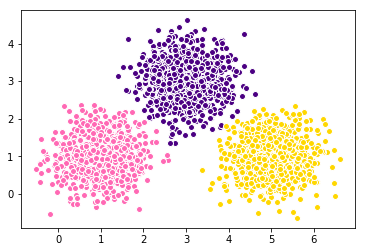

In [6]:
mini_batch_k_means = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=100, n_init=1, max_no_improvement=10, verbose=0, random_state=0)
mini_batch_k_means.fit(X)

plotClustering(X, mini_batch_k_means.labels_)

### Grupowanie za pomocą Birch bez wtórnego grupowania

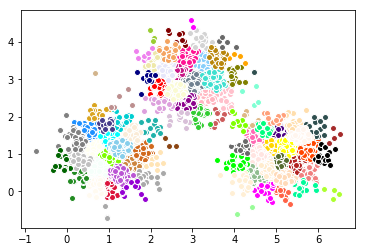

silhouette score:  0.303508287072
dunn index:  0.00537841318157
DB index:  0.014811246938


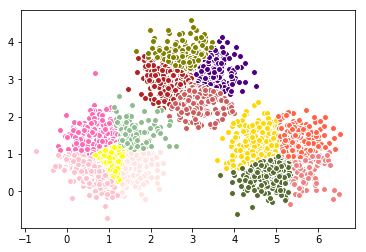

silhouette score:  0.30055717768
dunn index:  0.00429633764178
DB index:  0.0922006853803


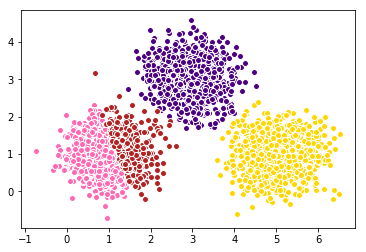

silhouette score:  0.534978927364
dunn index:  0.00403583316382
DB index:  0.359226979583


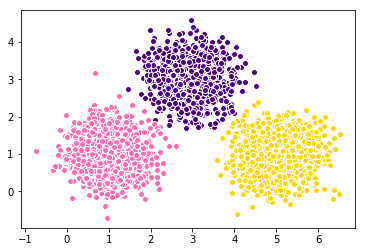

silhouette score:  0.679752286561
dunn index:  0.0298570201569
DB index:  0.164826610468


In [37]:
#threshold - minimal radius, below which a node is splitted
for i in [1, 2, 3, 4]:
    plt.figure(i)
    birch = Birch(threshold=0.25*i, n_clusters=None)
    birch.fit(X)
    plotClustering(X, birch.labels_)
    countCoeffs(X, birch.labels_, birch.subcluster_centers_ )

### Grupowanie za pomocą Birch z wtórnym grupowaniem

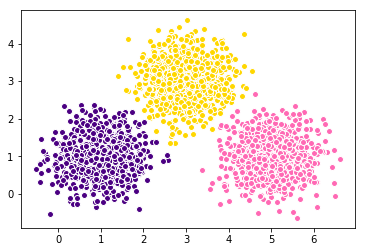

In [8]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)

plotClustering(X, birch.labels_)

### Grupowanie za pomocą DBScan

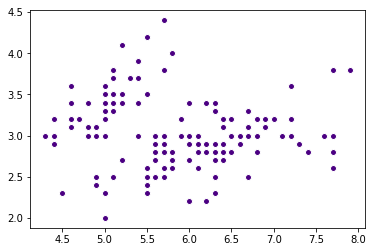

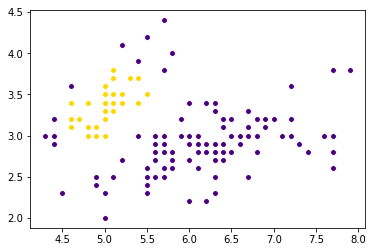

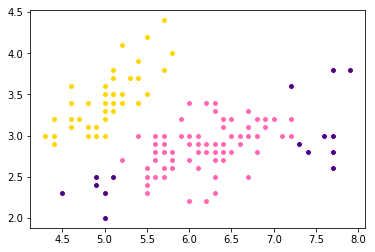

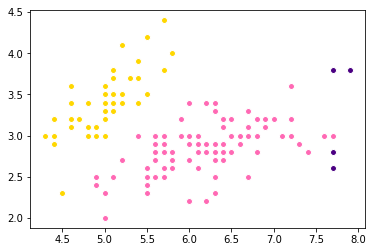

In [21]:
#eps - max distance between x and y to put y in neighborhood of x
for i in [1, 2, 3, 4]:
    plt.figure(i)
    dbscan = DBSCAN(eps=0.25*i, min_samples=25)
    dbscan.fit(X)
    dbscan.labels_[:]+=1
#    print(dbscan.labels_)
    plotClustering(X, dbscan.labels_)

## 2. Drugi zestaw danych
Dane IRIS

In [13]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data

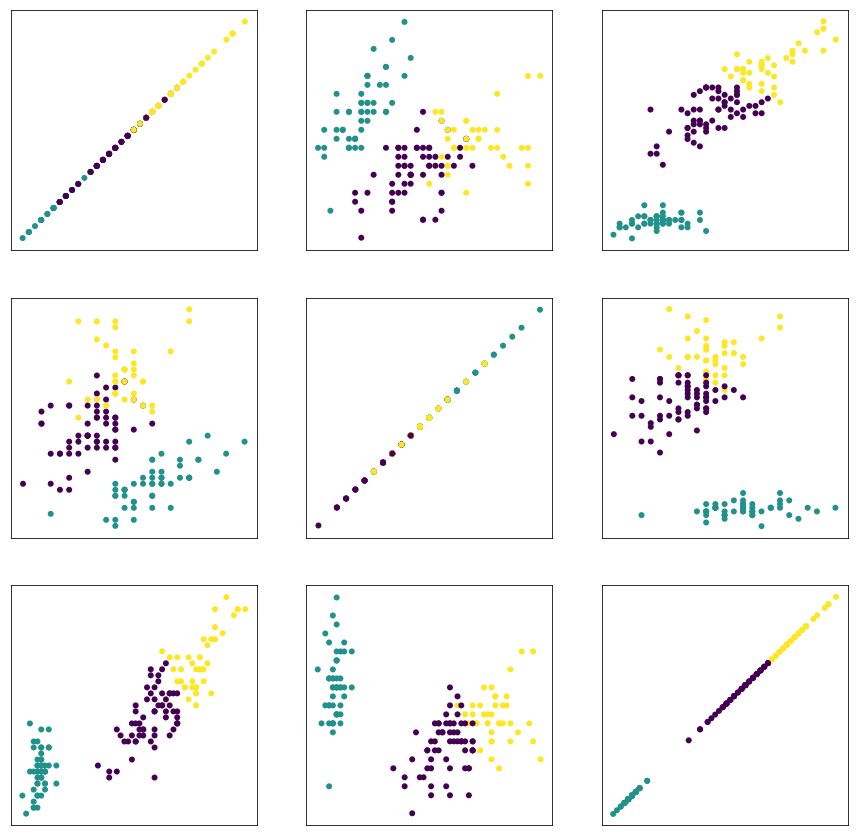

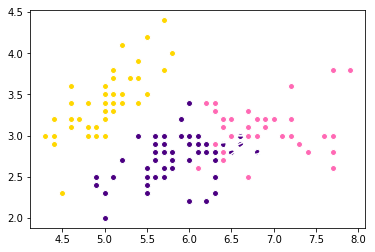

In [14]:
k_means = KMeans(init='k-means++', n_clusters=3, n_init=1)
k_means.fit(X)

plot_data(X, range(3), k_means.labels_, None)
plotClustering(X[:, :2], k_means.labels_)

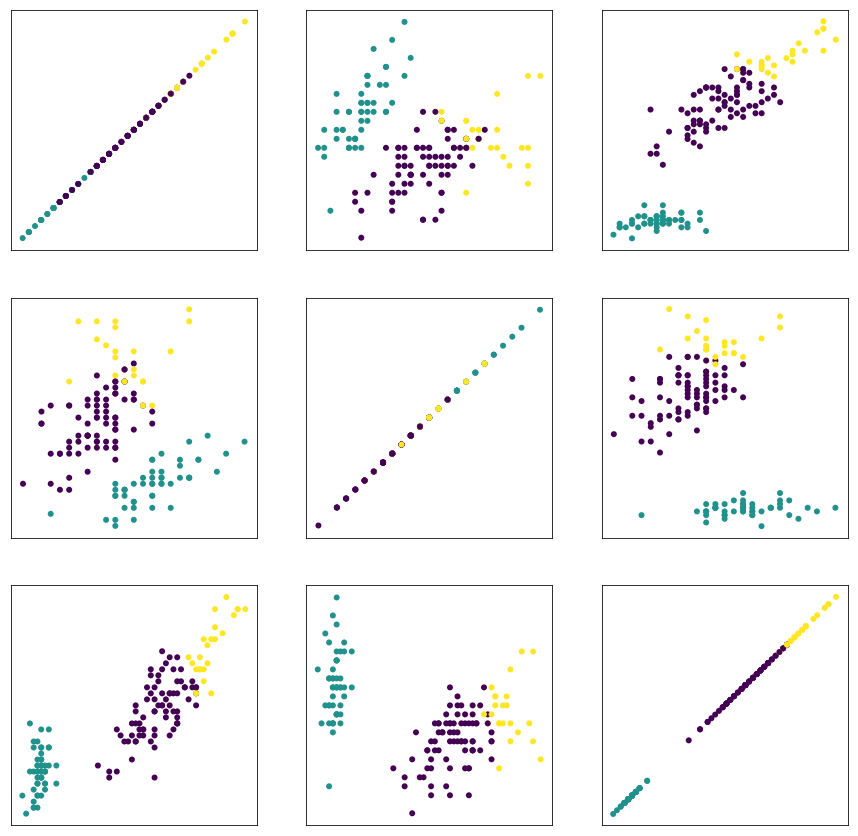

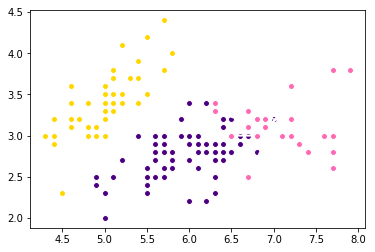

In [15]:
birch = Birch(threshold=0.75, n_clusters=3)
birch.fit(X)
plot_data(X, range(3), birch.labels_, None)

plotClustering(X[:, :2], birch.labels_)

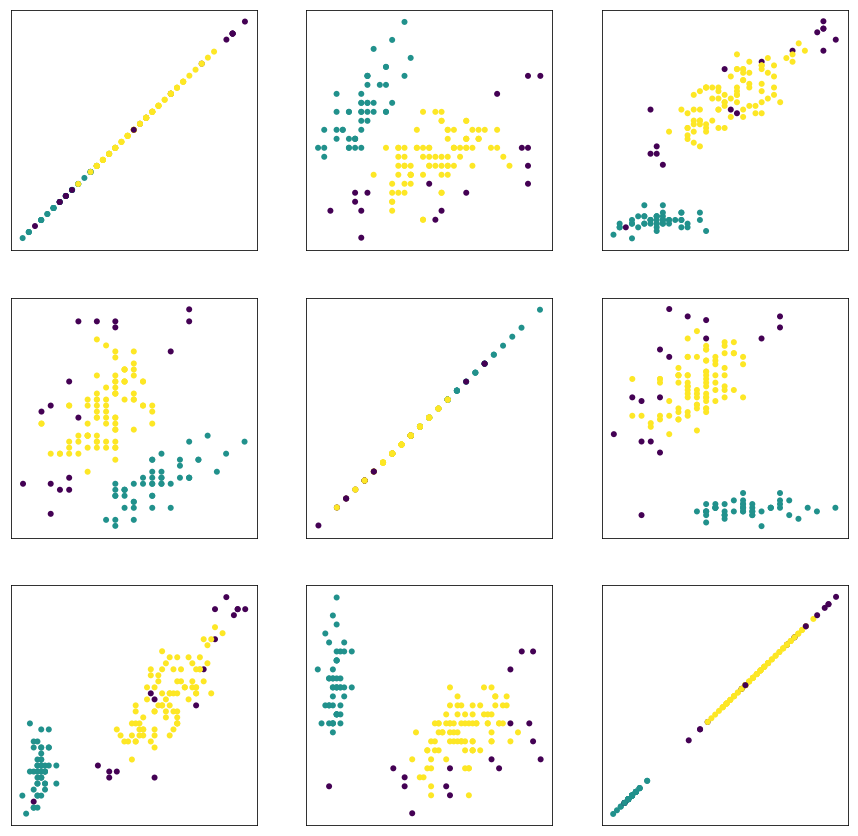

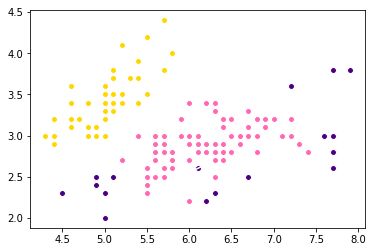

In [22]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
dbscan.labels_[:]+=1

plot_data(X, range(3), dbscan.labels_, None)

plotClustering(X[:, :2], dbscan.labels_)